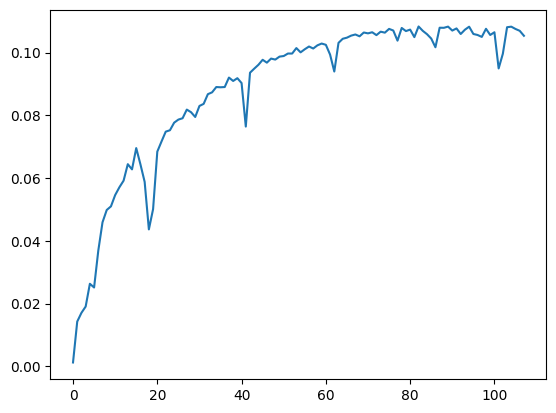

In [16]:
plt.plot(val_corrs)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader

In [2]:
# additional packages
# pip install hiera-transformer
# pip install -U pytorch_warmup

# Hyperparameters

In [3]:
video_size = [72, 128]
chunk_size = 8
dim_head = 64
num_heads = 4

### get dataloaders

In [4]:
from experanto.dataloaders import get_multisession_dataloader

from experanto.configs import DEFAULT_CONFIG as cfg
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

In [5]:
cfg.dataset.global_chunk_size = 8
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.sample_stride = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=128
cfg.dataloader.pin_memory=True
cfg.dataloader.shuffle=True

train_dl = get_multisession_dataloader(full_paths, cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### get Hiera backbone

In [6]:
# pip install hiera-transformer
from hiera import Hiera
tiny_hiera = Hiera(input_size=(chunk_size, video_size[0], video_size[1]),
                     num_heads=1,
                     embed_dim=96,
                     stages=(2, 2), # 4 transformer layers 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(1, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

tiny_hiera = tiny_hiera.cuda().to(torch.float32);
example_input = torch.ones(8,1,8,72,128).to("cuda", torch.float32)
out = tiny_hiera(example_input, return_intermediates=True);
hiera_output = out[-1][-1]
hiera_output.shape # (b, t, h, w, c): (8, 4, 9, 16, 192)


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([8, 8, 9, 16, 192])

# Model definition

In [7]:
class MouseHieraSmall(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 chunk_size,
                 dim=192,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.neuron_proj = nn.Linear(dim_head * num_heads, chunk_size, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = nn.Softplus(beta=0.5) # probably a much better activation than ELU+1
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, 
                                                   in_features=dim_head*num_heads,
                                                   dim_head=dim_head, 
                                                   num_heads=num_heads, 
                                                  )
            
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        x = x.view(b, -1, d) # (B, t*h*w, D)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2] # number of neurons
        q = q.repeat(b, 1, 1, 1) # repeat query for number of batches
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        o = F.scaled_dot_product_attention(q, k, v)
            
        # (B, H, S, D) -> (B, N, D), with N = num_neurons
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + self.readout[key].bias
        o = self.activation(o)
        return o

# Readout 

In [8]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        dim_head=32,
        num_heads=4,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        super().__init__()
        factory_kwargs = {"device": device, "dtype": dtype}
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.init_std = init_std
        self.query = nn.Parameter(
            torch.empty(1, num_heads, unique_ids, dim_head, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, 1, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

### Build Model

In [9]:
backbone_dim = hiera_output[-1][-1].shape[-1]
model = MouseHieraSmall(backbone=tiny_hiera, 
                        dls=train_dl, 
                        chunk_size=chunk_size,
                        dim=backbone_dim, 
                        dim_head=dim_head,
                        num_heads=num_heads)

### performance boosts

In [10]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

torch._dynamo.config.cache_size_limit = 32
model = torch.compile(model).cuda().to(torch.float32)

# Trainer

In [11]:
# pip install -U pytorch_warmup
import pytorch_warmup as warmup

n_epochs = 5
lr = 1.0e-3

criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = AdamW(model.parameters(), lr=lr, weight_decay=0.1,)
warmup_scheduler = warmup.UntunedLinearWarmup(opt)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                          T_max=5e5, 
                                                          eta_min=1e-5)

# train - simple

In [ ]:
# the first 10 batches are slow because torch is compiling the model for each new input shape

for _ in range(n_epochs):
    for i, (key, batch) in tqdm(enumerate(train_dl)):
        videos = batch["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
        responses = batch["responses"].to("cuda", torch.float32, non_blocking=True)
        out = model(videos, key);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), gradient_clip_value,)
        opt.step()
        opt.zero_grad()
        with warmup_scheduler.dampening():
            lr_scheduler.step()
            
    # after each epoch, the times can be shuffled so there are new random starting points for all chunks
    for dataloader in train_dl.loaders.values():
        dataloader.dataset.shuffle_valid_screen_times()

# train messy

In [12]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 8
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=8
cfg.dataset.modality_config.screen.valid_condition = {"tier": "oracle"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size


cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
val_dl = get_multisession_dataloader(full_paths[3:4], cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
def val_step():
    targets, predictions = [],[]
    with torch.no_grad():
        for i, (k, b) in tqdm(enumerate(val_dl)):
            videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
            out = model(videos, k);
            predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
            targets.append(responses.to(torch.float32).cpu().numpy())
    r1 = np.vstack(np.vstack(predictions))
    r2 = np.vstack(np.vstack(targets))
    cs = []
    for n in range(7000):
        c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
        cs.append(c)
    val_corrs = np.stack(cs).mean()
    return val_corrs

In [ ]:
patience = 0
max_objective = 0
losses, corrs, lrs, val_corrs = [], [], [], []
for train_loop in range(1000):
    current_objective = val_step()
    if train_loop > 20:
        max_objective = np.max(np.array(val_corrs[:-1])[~np.isnan(val_corrs[:-1])])
    if current_objective < max_objective:
        patience += 1
    else:
        patience = 0
    if patience >25:
        break
    val_corrs.append(current_objective)
    print(val_corrs)
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
        out = model(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()
        
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
            print(opt.param_groups[0]['lr'])
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

101it [00:48,  1.19it/s]

0.1379566916194311
0.0009991730408811658


201it [01:35,  1.49it/s]

0.13146021784313955
0.0009991549729249061


260it [02:01,  2.14it/s]
17it [00:06,  2.81it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.17s/it]

0.13586279024361356
0.0009991440385101026


101it [00:48,  1.18it/s]

0.1302611253024289
0.000999125658422008


201it [01:34,  1.41it/s]

0.1297880642162557
0.0009991070832609278


260it [02:02,  2.13it/s]
17it [00:06,  2.80it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.30s/it]

0.14187541694985265
0.000999095844532295


101it [00:47,  1.31it/s]

0.13714832786518533
0.0009990769572697246


201it [01:36,  1.02it/s]

0.14128876648954156
0.0009990578749533958


260it [02:03,  2.11it/s]
17it [00:05,  3.22it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.50s/it]

0.12886488854099568
0.0009990463319409252


101it [00:48,  1.32it/s]

0.149109516648995
0.0009990269375542858


201it [01:34,  1.13it/s]

0.1360215316647132
0.0009990073481336355


260it [02:00,  2.16it/s]
17it [00:07,  2.31it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.75s/it]

0.14143010981933168
0.0009989955008681342


101it [00:47,  1.68it/s]

0.12662137213214367
0.000998975599409184


201it [01:34,  1.27it/s]

0.12931353497117065
0.0009989555029364904


260it [02:01,  2.15it/s]
17it [00:08,  2.11it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.37s/it]

0.13419427104664136
0.0009989433514495743


101it [00:47,  1.33it/s]

0.10845188252716105
0.000998922942971425


201it [01:34,  1.40it/s]

0.10211933868431011
0.0009989023395003188


260it [02:00,  2.16it/s]
17it [00:07,  2.34it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.48s/it]

0.10021183549408649
0.0009988898838244181


101it [00:47,  1.11it/s]

0.10817318770881605
0.0009988689683815344


201it [01:34,  1.16it/s]

0.12033721689745687
0.0009988478579670028


260it [02:00,  2.16it/s]
17it [00:07,  2.42it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.47s/it]

0.1302040817019955
0.0009988350981353577


101it [00:47,  1.39it/s]

0.14223826016333788
0.0009988136757835583


201it [01:33,  1.46it/s]

0.1381221023889213
0.00099879205848194


260it [02:00,  2.16it/s]
17it [00:04,  3.48it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.75s/it]

0.1496526744635348
0.000998778994528603


101it [00:48,  1.21it/s]

0.13984014527870609
0.000998757065325058


201it [01:34,  1.60it/s]

0.13929864949263504
0.0009987349411940427


260it [02:00,  2.15it/s]
17it [00:06,  2.48it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.31s/it]

0.1488851647003572
0.0009987215731538785


101it [00:50,  1.10it/s]

0.15042609412917363
0.0009986991371571127


201it [01:36,  1.48it/s]

0.14254912332522718
0.0009986765062557433


260it [02:03,  2.11it/s]
17it [00:07,  2.20it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.60s/it]

0.1531822279484971
0.0009986628341644274


101it [00:47,  1.27it/s]

0.13599046423923714
0.0009986398914343137


201it [01:33,  1.31it/s]

0.14194148520219238
0.0009986167538229866


260it [02:00,  2.15it/s]
17it [00:07,  2.31it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.44s/it]

0.1555743835673535
0.0009986027777170057


101it [00:47,  1.16it/s]

0.13914194138875935
0.000998579328314774


201it [01:33,  1.44it/s]

0.15233269634086583
0.00099855568405524


260it [02:00,  2.15it/s]
17it [00:07,  2.42it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.21s/it]

0.15792096344968387
0.0009985414039718945


101it [00:47,  1.23it/s]

0.14242112396354695
0.000998517447960125


201it [01:34,  1.10it/s]

0.14393654797966343
0.000998493297115483


260it [02:00,  2.15it/s]
17it [00:05,  3.31it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.64s/it]

0.14086056921450893
0.0009984787130928809


101it [00:48,  1.36it/s]

0.14644740009692653
0.0009984542505355055


201it [01:35,  1.20it/s]

0.1462040197868948
0.000998429593170208


260it [02:01,  2.14it/s]
17it [00:06,  2.45it/s]


[np.float64(0.0012227522633072628), np.float64(0.014266847345772762), np.float64(0.01704850039682822), np.float64(0.019050164088542453), np.float64(0.026311539100093873), np.float64(0.02512192743726275), np.float64(0.03690081686855129), np.float64(0.04591486768523209), np.float64(0.04983379752078515), np.float64(0.05098168845208985), np.float64(0.05458253604147172), np.float64(0.057062467103312836), np.float64(0.05917454454427611), np.float64(0.06443101734322294), np.float64(0.06277663099437883), np.float64(0.06956107602270868), np.float64(0.06436535452638108), np.float64(0.05878767413664309), np.float64(0.04364472652756542), np.float64(0.05009946026211384), np.float64(0.06843572372657555), np.float64(0.07166404509895878), np.float64(0.07480292038356683), np.float64(0.07524756375194636), np.float64(0.07766292533303744), np.float64(0.07864306736608741), np.float64(0.07907180455495842), np.float64(0.0818305600150294), np.float64(0.08100658256251761), np.float64(0.0794779097356144), np.fl

1it [00:01,  1.30s/it]

0.15964784913073823
0.0009984147052472718


101it [00:47,  1.26it/s]

0.15137173593367367
0.0009983897362095765


201it [01:32,  1.46it/s]

0.15441929983586003
0.0009983645723894246


218it [01:40,  2.51it/s]